In [61]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg import maps

write_output = False

In [62]:
# 1) Malla (plana, sin topografía)

nx, ny, nz = 30, 30, 30
dx, dy, dz = 10.0, 10.0, 10.0

x0x, x0y = -150.0, -150.0
x0z = -(nz * dz)    
mesh = TensorMesh([[(dx, nx)], [(dy, ny)], [(dz, nz)]], x0=[x0x, x0y, x0z])

# ---- SIN topografía: todas las celdas activas ----
ind_active = np.ones(mesh.nC, dtype=bool)
nC = int(ind_active.sum())
cell_centers = mesh.cell_centers.astype(float)  # (nC,3) = (mesh.nC,3)

# Para graficar (identidad en la práctica; no hay aire con NaN)
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

In [63]:
# 2) Geometría: esfera 
sphere_center = np.r_[0.0, 0.0, -80.0]
sphere_radius = 30.0

ind_sphere_all = model_builder.get_indices_sphere(
    sphere_center, sphere_radius, mesh.cell_centers
)  # (mesh.nC,) bool

ind_sphere = ind_sphere_all[ind_active] 

In [64]:
# 3) Modelo GRAV (contraste densidad)

background_density = 0.0
sphere_density = 0.2

Grav_model = background_density * np.ones(nC, dtype=float)
Grav_model[ind_sphere] = sphere_density

# 4) Modelo MAG (susceptibilidad)

halfspace_susc = 0.0
sphere_susc = 0.025

Mag_model = halfspace_susc * np.ones(nC, dtype=float)
Mag_model[ind_sphere] = sphere_susc

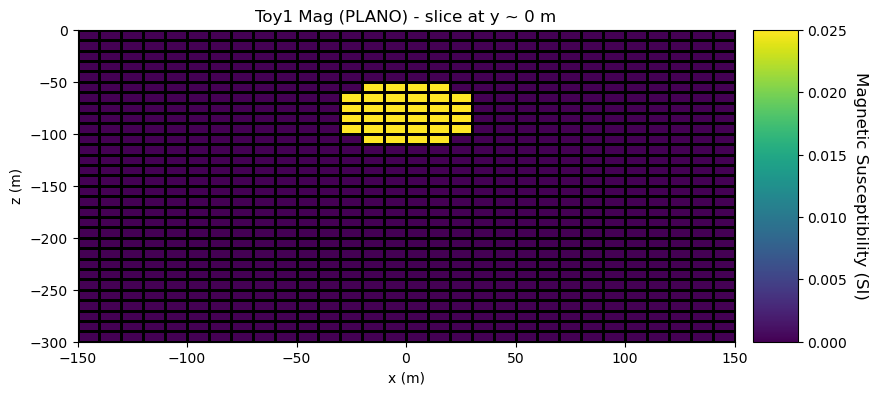

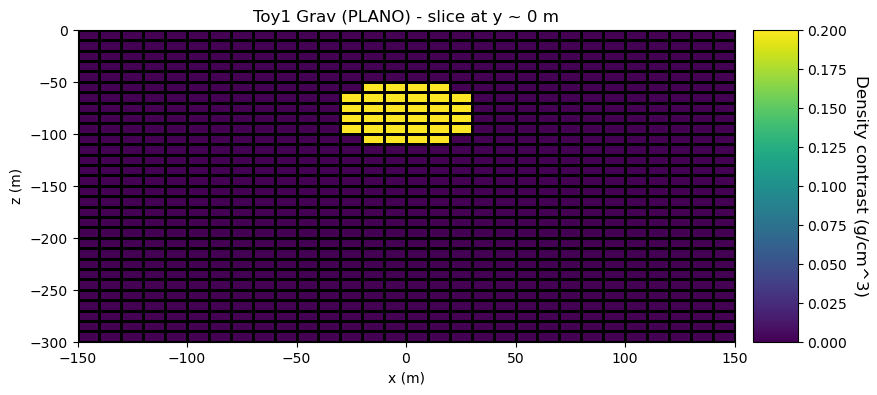

In [65]:
# 5) Plots

def plot_model_slice(model_active, title, cbar_label):
    full = plotting_map * model_active  # (mesh.nC,)

    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])

    mesh.plot_slice(
        full,
        normal="Y",
        ax=ax1,
        ind=int(mesh.shape_cells[1] / 2),
        grid=True,
        clim=(np.nanmin(full), np.nanmax(full)),
    )

    ax1.set_title(title)
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("z (m)")

    ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
    norm = mpl.colors.Normalize(vmin=np.nanmin(full), vmax=np.nanmax(full))
    cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
    cbar.set_label(cbar_label, rotation=270, labelpad=15, size=12)
    plt.show()

plot_model_slice(Mag_model,  "Toy1 Mag (PLANO) - slice at y ~ 0 m",  "Magnetic Susceptibility (SI)")
plot_model_slice(Grav_model, "Toy1 Grav (PLANO) - slice at y ~ 0 m", "Density contrast (g/cm^3)")

In [66]:
# 6) Guardar

np.savez(
    "Toy1_Grav.npz",
    cell_centers=cell_centers,     # (mesh.nC,3)
    Grav_model=Grav_model,         # (mesh.nC,)
    dx=float(dx), dy=float(dy), dz=float(dz),
)

np.savez(
    "Toy1_Mag.npz",
    cell_centers=cell_centers,     # (mesh.nC,3)
    Mag_model=Mag_model,           # (mesh.nC,)
    dx=float(dx), dy=float(dy), dz=float(dz),
)

print("Guardado: Toy1_Mag.npz, Toy1_Grav.npz")
print("nC:", nC, "| cell_centers:", cell_centers.shape)
print("Mag_model:", Mag_model.shape, "| Grav_model:", Grav_model.shape)

Guardado: Toy1_Mag.npz, Toy1_Grav.npz
nC: 27000 | cell_centers: (27000, 3)
Mag_model: (27000,) | Grav_model: (27000,)
